# Explore here

In [2]:
# Your code here

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

sns.set(
    style="whitegrid",     
    palette="pastel",              
)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")
total_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42


In [3]:
total_data.shape

(20640, 9)

In [4]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
total_data.drop_duplicates()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42
...,...,...,...,...,...,...,...,...,...
20635,1.56,25.0,5.05,1.13,845.0,2.56,39.48,-121.09,0.78
20636,2.56,18.0,6.11,1.32,356.0,3.12,39.49,-121.21,0.77
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22,0.92
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32,0.85


In [6]:
total_data.drop(["HouseAge", "AveRooms", "AveBedrms","Population","AveOccup","MedHouseVal"], axis = 1, inplace = True)
total_data.head()

,MedInc,Latitude,Longitude
0,8.33,37.88,-122.23
1,8.30,37.86,-122.22
2,7.26,37.85,-122.24
3,5.64,37.85,-122.25
4,3.85,37.85,-122.25


In [7]:
total_data.isnull().sum().sort_values(ascending=False) / len(total_data)

MedInc       0.0
Latitude     0.0
Longitude    0.0
dtype: float64

<Axes: xlabel='Longitude', ylabel='Latitude'>

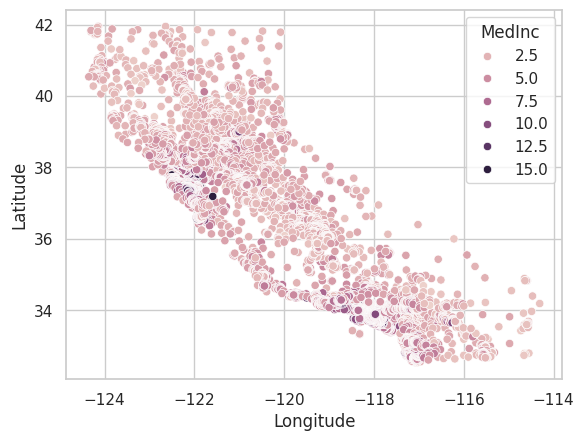

In [8]:
sns.scatterplot(data = total_data, x = 'Longitude', y = 'Latitude', hue = 'MedInc')

In [9]:
features = ['MedInc', 'Latitude', 'Longitude']
df_feat = total_data[features].dropna()

X_train, X_test = train_test_split(df_feat, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test  shape:", X_test.shape)

Train shape: (16512, 3)
Test  shape: (4128, 3)


In [10]:
import numpy as np
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6, random_state=42, n_init=10)
model.fit(total_data)

y_test = model.predict(X_test)
y_train = model.predict(X_train)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal  = scaler.transform(X_test)

In [14]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')  
kmeans.fit(X_train_scal)


,n_clusters,6
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [15]:
y_train = kmeans.labels_
y_test  = kmeans.predict(X_test_scal)

In [25]:
X_train_feat = X_train[features].copy()
X_test_feat  = X_test[features].copy()

X_train_label = X_train_feat.copy()
X_train_label["cluster"] = y_train

print(X_train_label['cluster'].value_counts())
print(X_train_label.head())

cluster
3    5421
5    3598
1    3554
0    2474
4     982
2     483
Name: count, dtype: int64
       MedInc  Latitude  Longitude  cluster
14196    3.26     32.71    -117.03        3
8267     3.81     33.77    -118.16        3
17445    4.16     34.66    -120.48        1
14265    1.94     32.69    -117.11        3
2271     3.55     36.78    -119.80        5


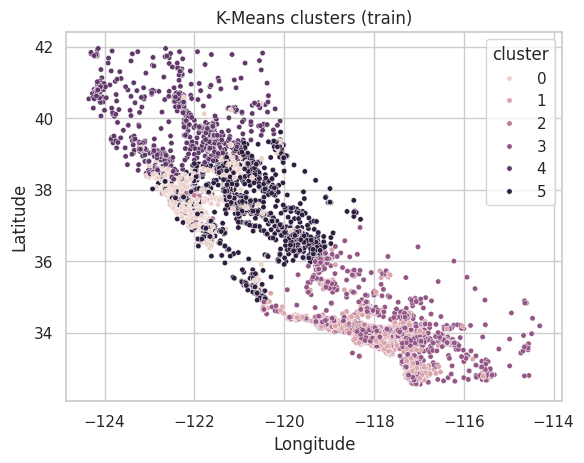

In [26]:
sns.scatterplot(
    data=X_train_label,
    x="Longitude", y="Latitude",
    hue="cluster", s=15
)
plt.title("K-Means clusters (train)")
plt.show()

KNN 

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracy_results = []

for dataset in [
    X_train,
    X_train_scal,
    X_train_label,
]:
    model = KNeighborsClassifier(
        n_neighbors=5, 
        metric='euclidean', 
        weights='distance',
)
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_results.append(accuracy_score(y_train, y_pred))

print("Accuracy:", accuracy_results)
print("Mejor Accuracy:", max(accuracy_results))

Accuracy: [1.0, 1.0, 1.0]
Mejor Accuracy: 1.0


In [29]:
model = KNeighborsClassifier(
        n_neighbors=5, 
        metric='euclidean', 
        weights='distance',
)
model.fit(X_train_label, y_train)
y_pred_test = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy en test:", accuracy)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- cluster


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

In [ ]:
cr = classification_report(y_test, y_pred_test)
print("Classificaion report:\n", cr)

rep = classification_report(
    y_test, y_pred_test,
    output_dict=True,
    target_names=["0 (baja)", "1 (media)", "2 (alta)"]
)
total_data = pd.DataFrame(rep).T

heat = total_data.loc[["0 (baja)", "1 (media)", "2 (alta)"], ["precision", "recall", "f1-score"]]

sns.heatmap(heat, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="Blues")
plt.title("Classification Report (heatmap)")
plt.ylabel("Clase"); plt.xlabel("Métrica")
plt.show()

NameError: name 'classification_report' is not defined